### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2021 Semester 2

## Final Assignment 

**Student Name:**    `Tiaohao Shi & Hangyu Liu`

**Student ID:**     `629394 & 1046223`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from multiprocessing.pool import ThreadPool
import itertools as it
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold

### 1. read files

In [2]:
train_df = pd.read_csv('COMP90086_2021_Project_train/train.csv', header=0)
test_df = pd.read_csv('COMP90086_2021_Project_test/imagenames.csv', header=0)

train_path = './COMP90086_2021_Project_train/train/'
test_path = './COMP90086_2021_Project_test/test/'
filetype = '.jpg'

# 2. SIFT + FLANN 

### 2a. SIFT train feature extraction

In [ ]:
# SIFT train feature extraction
# trainning flann model
sift = cv2.SIFT_create()
train_desc = []
train_kp = []

flann_params = dict(algorithm = 1, trees = 5)
matcher = cv2.FlannBasedMatcher(flann_params, {})

for img in train_df['id']:
    img = img + filetype
    image = cv2.imread(os.path.join(train_path, img), cv2.IMREAD_GRAYSCALE)
    kp, desc = sift.detectAndCompute(image, None)
    train_kp.append(kp)
    train_desc.append(desc)
    matcher.add([desc])

matcher.train()

### 2b.FLANN matching

In [ ]:
# SIFT main function
test_x = []
test_y = []

ratio_thresh = 0.7

for img in test_df['id']:
    img = img + filetype
    image = cv2.imread(os.path.join(test_path, img), cv2.IMREAD_GRAYSCALE)
    kp1, desc1 = sift.detectAndCompute(image, None)
    matches = matcher.knnMatch(desc1, k=2)

    # find good_matches
    good_matches = [ [] for _ in range(7500)]
    for m, n in matches:
        good_matches[m.imgIdx].append(m.trainIdx)
        good_matches[n.imgIdx].append(n.trainIdx)
        # good_matches[d.imgIdx].append(d.trainIdx)
    for i in range(len(good_matches)):
        l = len(set(good_matches[i]))
        good_matches[i] = (i,l)
    good_matches.sort(key=lambda tup: tup[1], reverse=True)

    # verify match is good
    flann_params = dict(algorithm = 1, trees = 5)
    matcher1 = cv2.FlannBasedMatcher(flann_params, {})

    best_index = []
    for match in good_matches[:5]:
        desc2 = train_desc[match[0]]
        matches = matcher1.knnMatch(desc1, desc2, 2)

        good = []
        for m, n in matches:
            if m.distance < ratio_thresh * n.distance:
                good.append(m.trainIdx)
        l = len(set(good))
        best_index.append((match[0],l))
    best_index.sort(key=lambda tup: tup[1], reverse=True)

    if best_index[1][0] > 10:
        x = 0.5 * (train_df.at[best_index[0][0], 'x'] + train_df.at[best_index[1][0], 'x'])
        y = 0.5 * (train_df.at[best_index[0][0], 'y'] + train_df.at[best_index[1][0], 'y'])
    else:
        x = train_df.at[best_index[0][0], 'x']
        y = train_df.at[best_index[0][0], 'y']
    test_x.append(x)
    test_y.append(y)

### 2c. Save the prediction

In [6]:
assert len(test_x) == test_df.shape[0]

test_df['x'] = test_x
test_df['y'] = test_y
test_df.to_csv('sift_flann_prediction.csv', index=False, header=True)

### 2d. experiments on SIFT result

In [ ]:
# test step 1
test_idx = 889
img = test_df.at[test_idx, 'id'] + filetype
image = cv2.imread(os.path.join(test_path, img), cv2.IMREAD_GRAYSCALE)
kp1, desc1 = sift.detectAndCompute(image, None)
matches = matcher.knnMatch(desc1, k=2)

good_matches = [ [] for _ in range(7500)]

for m, n in matches:
    good_matches[m.imgIdx].append(m.trainIdx)
    good_matches[n.imgIdx].append(n.trainIdx)
    # good_matches[d.imgIdx].append(d.trainIdx)
for i in range(len(good_matches)):
    l = len(set(good_matches[i]))
    good_matches[i] = (i,l)
good_matches.sort(key=lambda tup: tup[1], reverse=True)
print(good_matches[0], good_matches[1], good_matches[2])

# Test step 2
ratio_thresh = 0.7

flann_params = dict(algorithm = 1, trees = 5)
matcher1 = cv2.FlannBasedMatcher(flann_params, {})

best_index = []
for match in good_matches[:10]:
    desc2 = train_desc[match[0]]
    kp2 = train_kp[match[0]]
    matches = matcher1.knnMatch(desc1, desc2, 2)

    ptsA = []
    ptsB = []
    good = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            # ptsA.append(kp1[m.queryIdx].pt)
            # ptsB.append(kp2[m.trainIdx].pt)
            good.append(m.trainIdx)
    l = len(set(good))        
    # ptsA = np.float32(ptsA).reshape(-1, 1, 2)
    # ptsB = np.float32(ptsB).reshape(-1, 1, 2)
    # _, status = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, ransacReprojThreshold = 2, maxIters = 400)
    # success = status.ravel().tolist()
    # l = success.count(1)

    best_index.append((match[0],l))
best_index.sort(key=lambda tup: tup[1], reverse=True)
print(best_index[0], best_index[1])   

In [ ]:
# bad test image
# 14(613) 30 81 99 111 131 145 147 189 209 215 329 347 348 360 404 411 457 460 508 518 519 524 537 550 584 
# 625 = IMG4912_5 643 646 672 700 703(633) 707 735 737 750 757 787 799 811 821 826 828 832 834 842 844
# 853 = IMG5140_5 855 874 877 888 889(7105?) 945 955 957 958 960 961 977 991 1023 1056 1057 1061
# 1082= IMG5639_2 1086 1094 1107 1110 1131 1147

In [5]:
# display some images
test_img1 = test_df.at[14, 'id'] + filetype
test_img2 = train_df.at[613, 'id'] + filetype

test_image1 = cv2.imread(os.path.join(test_path, test_img1), cv2.IMREAD_GRAYSCALE)
test_image2 = cv2.imread(os.path.join(test_path, test_img2), cv2.IMREAD_GRAYSCALE)

test_kp1, test_desc1 = sift.detectAndCompute(test_image1, None)
test_kp2, test_desc2 = sift.detectAndCompute(test_image2, None)

kp1_with_size = cv2.drawKeypoints(test_image1,test_kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_with_size = cv2.drawKeypoints(test_image2,test_kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.subplots(figsize=(25, 25)) 

plt.subplot(1,2,1)
plt.imshow(kp1_with_size)  
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(kp2_with_size)  
plt.axis('off')

plt.show()

NameError: name 'sift' is not defined

In [ ]:
# test step 3 - check match images
ptsA = []
ptsB = []
for i in range(2):
    img = train_df.at[best_index[i][0], 'id'] + filetype
    image2 = cv2.imread(os.path.join(train_path, img), cv2.IMREAD_GRAYSCALE)
    kp2, desc2 = sift.detectAndCompute(image2, None)

    img = test_df.at[test_idx, 'id'] + filetype
    image1 = cv2.imread(os.path.join(test_path, img), cv2.IMREAD_GRAYSCALE)
    kp1, desc1 = sift.detectAndCompute(image1, None)

    flann_params = dict(algorithm = 1, trees = 5)
    matcher1 = cv2.FlannBasedMatcher(flann_params, {})
    matches = matcher1.knnMatch(desc1, desc2, 2)

    # Create a mask to draw all good matches
    matchesMask = []
    ptsL = []
    ptsR = []

    # Store all good matches as per Lowe's Ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            ptsL.append(kp1[m.queryIdx].pt)
            ptsR.append(kp2[m.trainIdx].pt)
            good.append(m)
            matchesMask.append([1,0]) # Match
        else:
            matchesMask.append([0,0]) # Mismatch

    # RANSAC find good matches
    ptsA.append(np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2))
    ptsB.append(np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2))
    H, status = cv2.findHomography(ptsA[i], ptsB[i], cv2.RANSAC, ransacReprojThreshold = 3, maxIters = 400)

    success = status.ravel().tolist()

    # Print total number of successful matches between two images
    print("\nNumber of successful matches between two images: ", success.count(1)) # Returns the number of 1 in the success list
    # print("\nNumber of successful matches between two images: ",len(good)) # Returns the number of good matches

    # Draw our inliers (if successfully found the object) or all matching keypoints (if failed)
    draw_params = dict(#matchColor = (0,255,0), # draw in a specific colour
                    #singlePointColor = (255,0,0), # draw in a specific colour
                    matchesMask = success, # draw only inliers
                    flags = 2)

    success_matches = cv2.drawMatches(image1,kp1,image2,kp2,good,None,**draw_params)

    plt.subplots(figsize=(25, 25)) 
    plt.subplot(1,1,1)
    plt.imshow(success_matches) 
    # plt.title('All successful matches')
    plt.axis('off')
    plt.show()


### 2e (Not in used). Mutiview depth

In [ ]:
# test step 4 - mutliview depth
# NOT IN USED 
def findRelativePose(image1, image2, K):

    kp1, desc1 = sift.detectAndCompute(image1, None)
    kp2, desc2 = sift.detectAndCompute(image2, None)

    matcher1 = cv2.BFMatcher()
    matches = matcher1.knnMatch(desc1, desc2, 2)

    good = []
    # Store all good matches as per Lowe's Ratio test.
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    ptsA = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    E, mask = cv2.findEssentialMat(points1=ptsA, points2=ptsB, cameraMatrix=K, method=cv2.RANSAC, prob=0.99999)
    _, rvec, tvec, _ = cv2.recoverPose(E, ptsA, ptsB, K, mask=mask)
    # num, rvec, tvec, norm = cv2.decomposeHomographyMat(H, K)

    return rvec, tvec

# camera intrinsic matrix
img = train_df.at[0, 'id'] + filetype
temp_img = cv2.imread(os.path.join(rootpath, img), cv2.IMREAD_GRAYSCALE)
cy, cx = temp_img.shape
cy, cx = cy/2, cx/2
fovX = 73.7 * math.pi / 180
fovY = 53.1 * math.pi / 180
fx = cx / math.tan(fovX / 2)
fy = cy / math.tan(fovY / 2)

K = [[fx, 0, cx],
     [0, fy, cy],
     [0,  0,  1]]

K = np.array(K) # camera intrinsic matrix
# print('camera intrinsic matrix:')
# print(K)

# find essential matrix
tvec = []
rvec = []
for i in range(2):
     E, mask = cv2.findEssentialMat(ptsA[i], ptsB[i], K)
     _, rvec1, tvec1, _ = cv2.recoverPose(E, ptsA[i], ptsB[i], K, mask=mask)
     rvec.append(rvec1)
     tvec.append(tvec1)

# compute query image position
x1, y1 = train_df.at[best_index[0][0], 'x'], train_df.at[best_index[0][0], 'y']
x2, y2 = train_df.at[best_index[1][0], 'x'], train_df.at[best_index[1][0], 'y']
# solve four equations
""" 
f1 and f2 are scale factor for train image 1 and train image 2
(t11, t12) are relative pose between query image and train image 1
(t21, t22) are relative pose between query image and train image 2

f1*t11 + x0 = x1
f1*t12 + y0 = y1 
f2*t21 + x0 = x2
f2*t22 + y0 = y2
"""
tvec1 = tvec[0]
tvec2 = rvec[0] @ tvec[1]

A = [[tvec1[0][0], 0, 1, 0],
     [tvec1[2][0], 0, 0, 1], 
     [0, tvec2[0][0], 1, 0],
     [0, tvec2[2][0], 0, 1]]
A = np.matrix(A)
B = np.matrix([[x1], [y1], [x2], [y2]])
A_inverse = np.linalg.inv(A)
X = A_inverse * B

print('Image1 coordination: (%f, %f)    Image2 coordination: (%f, %f)' % (B[0], B[1], B[2], B[3]))
print('Query image coordination: (%f, %f)' % (X[2], X[3]))

fig, ax = plt.subplots()
ax.scatter(x1, y1)
ax.scatter(x2, y2)
# ax.scatter(X.item(2), X.item(3))

ax.annotate('image1', (x1, y1))
ax.annotate('image2', (x2, y2))
# ax.annotate('query',  (X.item(2), X.item(3)))

plt.show()

In [ ]:
# display multiview result
# NOT IN USED 
img1 = train_df.at[best_index[0][0], 'id'] + filetype
image1 = image2 = cv2.imread(os.path.join(rootpath, img1), cv2.IMREAD_GRAYSCALE)

img2 = train_df.at[best_index[1][0], 'id'] + filetype
image2 = image2 = cv2.imread(os.path.join(rootpath, img2), cv2.IMREAD_GRAYSCALE)


rvec, tvec = findRelativePose(image1, image2, K)

rvec1, tvec1 = findRelativePose(image1, image, K)

rvec2, tvec2 = findRelativePose(image, image2, K)

tvec2_ = rvec1.T @ tvec2

d12 = math.sqrt((x2-x1)**2 + (y2-y1)**2)
angle = math.atan(tvec[2]/tvec[0])

x2_1 = d12 * math.cos(angle)
y2_1 = d12 * math.sin(angle)

print(x2_1, y2_1)

print('tvec=', tvec.tolist())
print('tvec1=',tvec1.tolist())
print('tvec2=',tvec2.tolist())
print('tvec2_=',tvec2_.tolist())

In [ ]:
# test 4 epipolar geometry for camera pose estimation
# NOT IN USED
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)

F, mask = cv2.findFundamentalMat(ptsL,ptsR,cv2.FM_LMEDS)

ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# create a function to draw epilines over the images
# Epilines corresponding to the points in first image is drawn on second image
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1,img2

# Find epilines corresponding to points in right image 
# and draw its lines on left image
linesL = cv2.computeCorrespondEpilines(ptsR.reshape(-1,1,2), 2, F)
linesL = linesL.reshape(-1,3)
img5, img6 = drawlines(image1, image2, linesL, ptsL, ptsR)

# Find epilines corresponding to points in left image 
# and draw its lines on right image
linesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1,1,2), 1, F)
linesR = linesR.reshape(-1,3)
img3, img4 = drawlines(image2, image1, linesR, ptsR, ptsL)

# Display the results
plt.subplots(figsize=(25, 25)) 

plt.subplot(1,2,1)
plt.imshow(img5, cmap='gray')  
plt.title('Drawn on the left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img3, cmap='gray')  
plt.title('Drawn on the right image')
plt.axis('off')

plt.show() 

# 3. ORB

### 3a. ORB feature extraction

In [ ]:
# ORB train feature extraction
# trainning flann model
orb = cv2.ORB_create(nfeatures=2000)
train_desc = []
train_kp = []

flann_params= dict(algorithm = 6, # FLANN_INDEX_LSH
                   table_number = 24, # 12
                   key_size = 30,     # 20
                   multi_probe_level = 2) #2
search_params = dict(checks=50)
matcher = cv2.FlannBasedMatcher(flann_params, search_params)

for img in train_df['id']:
    img = img + filetype
    image = cv2.imread(os.path.join(train_path, img), cv2.IMREAD_GRAYSCALE)
    kp, desc = orb.detectAndCompute(image, None)
    train_kp.append(kp)
    train_desc.append(desc)
    matcher.add([desc])

matcher.train()

### 3b. Matching

In [ ]:
test_x = []
test_y = []
ratio_thresh = 0.75

matcher1 = cv2.BFMatcher_create(cv2.NORM_HAMMING)

for img in test_df['id']:
    img = img + filetype
    image = cv2.imread(os.path.join(test_path, img), cv2.IMREAD_GRAYSCALE)
    kp1, desc1 = orb.detectAndCompute(image, None)
    matches = matcher.knnMatch(desc1, k=2)

    # find multiple good_matches by flann
    good_matches = [ [] for _ in range(7500)]
    for m, n in matches:
        good_matches[m.imgIdx].append(m.trainIdx)
        good_matches[n.imgIdx].append(n.trainIdx)
        # good_matches[d.imgIdx].append(d.trainIdx)
    for i in range(len(good_matches)):
        l = len(set(good_matches[i]))
        good_matches [i] = (i,l)
    good_matches.sort(key=lambda tup: tup[1], reverse=True)

    # find best match
    best_index = []
    flag = 0
    for match in good_matches[:5]:
        desc2 = train_desc[match[0]]
        kp2 = train_kp[match[0]]
        matches = matcher1.knnMatch(desc1, desc2, 2)

        good = []
        for m, n in matches:
            if m.distance < ratio_thresh * n.distance:
                good.append(m)
        l = len(good)

        if len(good) >= 4:
            ptsA = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
            ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
            _, status = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, ransacReprojThreshold = 4, maxIters = 400)
            success = status.ravel().tolist()
            l = success.count(1)
            flag = 1
        best_index.append((match[0], l, flag))

    best_index.sort(key=lambda tup: (tup[2], tup[1]), reverse=True)
    if len(best_index) == 0:
        best_index = good_matches
    print(img, best_index)
    x = train_df.at[best_index[0][0], 'x']
    y = train_df.at[best_index[0][0], 'y']
    test_x.append(x)
    test_y.append(y)

### 3c. Save the prediction

In [7]:
test_df['x'] = test_x
test_df['y'] = test_y
test_df.to_csv('orb_flann_prediction.csv', index=False, header=True)

### 3d.  experiments on ORB results

In [14]:
# test step 1
test_idx = 550
img = test_df.at[test_idx, 'id'] + filetype
image = cv2.imread(os.path.join(test_path, img), cv2.IMREAD_GRAYSCALE)
kp1, desc1 = orb.detectAndCompute(image, None)
matches = matcher.knnMatch(desc1, k=2)

good_matches = [ [] for _ in range(7500)]

for m,n in matches:
    good_matches[m.imgIdx].append(m.trainIdx)
    good_matches[n.imgIdx].append(n.trainIdx)
    # good_matches[d.imgIdx].append(d.trainIdx)
for i in range(len(good_matches)):
    l = len(set(good_matches[i]))
    good_matches[i] = (i,l)
good_matches.sort(key=lambda tup: tup[1], reverse=True)
print(good_matches[0], good_matches[1], good_matches[2])

(100, 1) (176, 1) (258, 1)


In [16]:
# Test step 2
ratio_thresh = 0.75

matcher1 = cv2.BFMatcher_create(cv2.NORM_HAMMING)

best_index = []
for match in good_matches[:10]:
    desc2 = train_desc[match[0]]
    kp2 = train_kp[match[0]]
    matches = matcher1.knnMatch(desc1, desc2, k=2)

    good = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            # print(m.distance, m.imgIdx, m.trainIdx, m.queryIdx, n.distance, n.imgIdx, n.trainIdx, n.queryIdx)
            good.append(m)

    # l = len(set(good))
    # best_index.append((match[0], l))
    if len(good) > 4:
        ptsA = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
        _, status = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, ransacReprojThreshold = 4, maxIters = 400)
        success = status.ravel().tolist()
        l = success.count(1)
        best_index.append((match[0],l))
best_index.sort(key=lambda tup: tup[1], reverse=True)
print(best_index)       

(613, 1) (100, 0)


In [ ]:
# test step 3 - check match images
img = train_df.at[best_index[0][0], 'id'] + filetype
image2 = cv2.imread(os.path.join(train_path, img), cv2.IMREAD_GRAYSCALE)
kp2, desc2 = orb.detectAndCompute(image2, None)

img = test_df.at[test_idx, 'id'] + filetype
image1 = cv2.imread(os.path.join(test_path, img), cv2.IMREAD_GRAYSCALE)
kp1, desc1 = orb.detectAndCompute(image1, None)

matches = matcher1.knnMatch(desc1, desc2, k=2)

# Create a mask to draw all good matches
matchesMask = []
ptsL = []
ptsR = []

# Store all good matches as per Lowe's Ratio test.
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        ptsL.append(kp1[m.queryIdx].pt)
        ptsR.append(kp2[m.trainIdx].pt)
        good.append(m)
        matchesMask.append([1,0]) # Match
    else:
        matchesMask.append([0,0]) # Mismatch

# RANSAC find good matches
ptsA = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
H, status = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, ransacReprojThreshold = 3, maxIters = 400)

success = status.ravel().tolist()

# Print total number of successful matches between two images
print("\nNumber of successful matches between two images: ", success.count(1)) # Returns the number of 1 in the success list


# Draw our inliers (if successfully found the object) or all matching keypoints (if failed)
draw_params = dict(#matchColor = (0,255,0), # draw in a specific colour
                   #singlePointColor = (255,0,0), # draw in a specific colour
                   matchesMask = success, # draw only inliers
                   flags = 2)

success_matches = cv2.drawMatches(image1,kp1,image2,kp2,good,None,**draw_params)

plt.subplots(figsize=(25, 25)) 
plt.subplot(1,1,1)
plt.imshow(success_matches)
plt.axis('off')
plt.show()

# 4. Deep-learning

### 4a. preparing feature extraction model

In [4]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

base_model = VGG19(weights='imagenet', input_shape=[490,680,3],include_top=False) 

for idx in range(len(base_model.layers)):
    print(base_model.get_layer(index = idx).name)

fea_model=tf.keras.Model(base_model.inputs, base_model.layers[-2].output)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


### 4b. read labels

In [5]:
train_label = []
for index, row in train_df.iterrows():
    x = row['x']
    y = row['y']
    train_label.append((x,y))
train_labels = np.array(train_label)
print(train_labels.shape)

(7500, 2)


### 4c. preparing training model

In [11]:
input_feature = keras.layers.Input((30,42,512,))
hidden1 = keras.layers.Conv2D(filters=128,kernel_size=(3,3), activation='relu')(input_feature)
hidden = keras.layers.Dense(16, activation='relu')(hidden1)
flat = keras.layers.Flatten()(hidden)
output = keras.layers.Dense(2, activation='linear')(flat)

model = keras.Model(input_feature, output)
model.compile(optimizer='adam',
                          loss ='mae',
                         metrics=['mae', 'acc'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 30, 42, 512)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 40, 128)       589952    
_________________________________________________________________
dense_4 (Dense)              (None, 28, 40, 16)        2064      
_________________________________________________________________
flatten_2 (Flatten)          (None, 17920)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 35842     
Total params: 627,858
Trainable params: 627,858
Non-trainable params: 0
_________________________________________________________________


### 4d. Incremental extraction and learning 

In [12]:
train_features = np.ndarray(shape=(1,30,42,512))
count = 0
start = 0 
for img in train_df['id']:
    img = img + filetype
    target_image = image.load_img(train_path+img, target_size=(490,680))
    target_image = image.img_to_array(target_image)
    target_image = preprocess_input(target_image)
    target_image = np.expand_dims(target_image, axis=0)
    features = fea_model.predict(target_image)
    train_features = np.append(train_features, features, axis=0)
    count += 1
    if count % 500 == 0:
        train_features = train_features[1:]
        labels = train_labels[start:count]
        x_train, x_valid, y_train, y_valid = train_test_split(train_features, labels, test_size=0.1, shuffle= True)
        model_his = model.fit(x_train, y_train,validation_data=(x_valid, y_valid) ,epochs=30, batch_size=100,shuffle=True)
        train_features = np.ndarray(shape=(1,30,42,512))
        start = count
        

Train on 450 samples, validate on 50 samples
Epoch 1/30
450/450 [==============================] - 15s 34ms/sample - loss: 44.7389 - mae: 44.7389 - acc: 0.5911 - val_loss: 31.9181 - val_mae: 31.9181 - val_acc: 0.7000
Epoch 2/30
450/450 [==============================] - 5s 11ms/sample - loss: 34.9400 - mae: 34.9400 - acc: 0.8178 - val_loss: 32.8344 - val_mae: 32.8344 - val_acc: 0.6600
Epoch 3/30
450/450 [==============================] - 5s 11ms/sample - loss: 28.1060 - mae: 28.1060 - acc: 0.8356 - val_loss: 30.2335 - val_mae: 30.2335 - val_acc: 0.7000
Epoch 4/30
450/450 [==============================] - 5s 10ms/sample - loss: 24.1671 - mae: 24.1671 - acc: 0.8733 - val_loss: 29.4580 - val_mae: 29.4580 - val_acc: 0.7800
Epoch 5/30
450/450 [==============================] - 5s 10ms/sample - loss: 19.7556 - mae: 19.7556 - acc: 0.9222 - val_loss: 30.9160 - val_mae: 30.9160 - val_acc: 0.8000
Epoch 6/30
450/450 [==============================] - 5s 10ms/sample - loss: 16.4967 - mae: 16.4967

Epoch 6/30
450/450 [==============================] - 5s 10ms/sample - loss: 12.1760 - mae: 12.1760 - acc: 0.9600 - val_loss: 21.6408 - val_mae: 21.6408 - val_acc: 0.9000
Epoch 7/30
450/450 [==============================] - 5s 10ms/sample - loss: 10.0655 - mae: 10.0655 - acc: 0.9689 - val_loss: 20.7780 - val_mae: 20.7780 - val_acc: 0.9200
Epoch 8/30
450/450 [==============================] - 5s 10ms/sample - loss: 8.9739 - mae: 8.9739 - acc: 0.9756 - val_loss: 20.9809 - val_mae: 20.9809 - val_acc: 0.9200
Epoch 9/30
450/450 [==============================] - 5s 10ms/sample - loss: 7.8222 - mae: 7.8222 - acc: 0.9889 - val_loss: 21.4785 - val_mae: 21.4785 - val_acc: 0.9000
Epoch 10/30
450/450 [==============================] - 5s 10ms/sample - loss: 7.0580 - mae: 7.0580 - acc: 0.9822 - val_loss: 21.4657 - val_mae: 21.4657 - val_acc: 0.9200
Epoch 11/30
450/450 [==============================] - 5s 10ms/sample - loss: 6.2512 - mae: 6.2512 - acc: 0.9911 - val_loss: 21.6341 - val_mae: 21.634

Epoch 24/30
450/450 [==============================] - 5s 10ms/sample - loss: 3.3248 - mae: 3.3248 - acc: 0.9933 - val_loss: 24.2194 - val_mae: 24.2194 - val_acc: 0.8400
Epoch 25/30
450/450 [==============================] - 5s 10ms/sample - loss: 3.3498 - mae: 3.3498 - acc: 0.9978 - val_loss: 24.7653 - val_mae: 24.7653 - val_acc: 0.8200
Epoch 26/30
450/450 [==============================] - 5s 10ms/sample - loss: 3.0995 - mae: 3.0995 - acc: 0.9978 - val_loss: 24.7038 - val_mae: 24.7038 - val_acc: 0.8200
Epoch 27/30
450/450 [==============================] - 5s 10ms/sample - loss: 3.0352 - mae: 3.0352 - acc: 0.9933 - val_loss: 24.4383 - val_mae: 24.4383 - val_acc: 0.8000
Epoch 28/30
450/450 [==============================] - 4s 10ms/sample - loss: 2.8142 - mae: 2.8142 - acc: 0.9956 - val_loss: 25.3505 - val_mae: 25.3505 - val_acc: 0.8200
Epoch 29/30
450/450 [==============================] - 5s 10ms/sample - loss: 3.0354 - mae: 3.0354 - acc: 0.9933 - val_loss: 24.9309 - val_mae: 24.930

Epoch 29/30
450/450 [==============================] - 4s 10ms/sample - loss: 3.6833 - mae: 3.6833 - acc: 0.9978 - val_loss: 20.7858 - val_mae: 20.7858 - val_acc: 0.9200
Epoch 30/30
450/450 [==============================] - 4s 10ms/sample - loss: 3.4734 - mae: 3.4734 - acc: 1.0000 - val_loss: 20.5332 - val_mae: 20.5332 - val_acc: 0.9200
Train on 450 samples, validate on 50 samples
Epoch 1/30
450/450 [==============================] - 10s 23ms/sample - loss: 20.5266 - mae: 20.5266 - acc: 0.8311 - val_loss: 18.0328 - val_mae: 18.0328 - val_acc: 0.8400
Epoch 2/30
450/450 [==============================] - 5s 11ms/sample - loss: 18.2107 - mae: 18.2107 - acc: 0.8844 - val_loss: 17.9202 - val_mae: 17.9202 - val_acc: 0.8400
Epoch 3/30
450/450 [==============================] - 5s 10ms/sample - loss: 14.9573 - mae: 14.9573 - acc: 0.8911 - val_loss: 17.9177 - val_mae: 17.9177 - val_acc: 0.8800
Epoch 4/30
450/450 [==============================] - 5s 10ms/sample - loss: 12.2539 - mae: 12.2539 -

Epoch 17/30
450/450 [==============================] - 5s 10ms/sample - loss: 3.3353 - mae: 3.3353 - acc: 0.9733 - val_loss: 17.3720 - val_mae: 17.3720 - val_acc: 0.9000
Epoch 18/30
450/450 [==============================] - 5s 10ms/sample - loss: 3.3808 - mae: 3.3808 - acc: 0.9844 - val_loss: 17.2331 - val_mae: 17.2331 - val_acc: 0.9000
Epoch 19/30
450/450 [==============================] - 5s 10ms/sample - loss: 3.3656 - mae: 3.3656 - acc: 0.9911 - val_loss: 17.3157 - val_mae: 17.3157 - val_acc: 0.8800
Epoch 20/30
450/450 [==============================] - 5s 10ms/sample - loss: 3.4351 - mae: 3.4351 - acc: 0.9889 - val_loss: 17.4530 - val_mae: 17.4530 - val_acc: 0.9000
Epoch 21/30
450/450 [==============================] - 5s 10ms/sample - loss: 3.4217 - mae: 3.4217 - acc: 0.9867 - val_loss: 17.8881 - val_mae: 17.8881 - val_acc: 0.8800
Epoch 22/30
450/450 [==============================] - 5s 10ms/sample - loss: 3.6631 - mae: 3.6631 - acc: 0.9867 - val_loss: 17.4179 - val_mae: 17.417

Epoch 5/30
450/450 [==============================] - 5s 10ms/sample - loss: 10.6682 - mae: 10.6682 - acc: 0.9400 - val_loss: 21.6942 - val_mae: 21.6942 - val_acc: 0.8600
Epoch 6/30
450/450 [==============================] - 5s 10ms/sample - loss: 8.5796 - mae: 8.5796 - acc: 0.9378 - val_loss: 22.2887 - val_mae: 22.2887 - val_acc: 0.8600
Epoch 7/30
450/450 [==============================] - 5s 10ms/sample - loss: 6.9453 - mae: 6.9453 - acc: 0.9667 - val_loss: 22.2184 - val_mae: 22.2184 - val_acc: 0.8400
Epoch 8/30
450/450 [==============================] - 5s 10ms/sample - loss: 6.1695 - mae: 6.1695 - acc: 0.9689 - val_loss: 21.5809 - val_mae: 21.5809 - val_acc: 0.8600
Epoch 9/30
450/450 [==============================] - 5s 10ms/sample - loss: 5.2394 - mae: 5.2394 - acc: 0.9822 - val_loss: 22.2927 - val_mae: 22.2927 - val_acc: 0.8400
Epoch 10/30
450/450 [==============================] - 5s 10ms/sample - loss: 4.5354 - mae: 4.5354 - acc: 0.9889 - val_loss: 21.8994 - val_mae: 21.8994 -

Epoch 23/30
450/450 [==============================] - 5s 10ms/sample - loss: 2.6111 - mae: 2.6111 - acc: 0.9889 - val_loss: 19.6093 - val_mae: 19.6093 - val_acc: 0.8600
Epoch 24/30
450/450 [==============================] - 5s 10ms/sample - loss: 2.5846 - mae: 2.5846 - acc: 0.9867 - val_loss: 19.7383 - val_mae: 19.7383 - val_acc: 0.9000
Epoch 25/30
450/450 [==============================] - 5s 10ms/sample - loss: 2.9104 - mae: 2.9104 - acc: 0.9911 - val_loss: 19.6496 - val_mae: 19.6496 - val_acc: 0.8600
Epoch 26/30
450/450 [==============================] - 5s 10ms/sample - loss: 2.6735 - mae: 2.6735 - acc: 0.9889 - val_loss: 19.4925 - val_mae: 19.4925 - val_acc: 0.8600
Epoch 27/30
450/450 [==============================] - 4s 10ms/sample - loss: 2.5761 - mae: 2.5761 - acc: 0.9867 - val_loss: 19.3972 - val_mae: 19.3972 - val_acc: 0.8800
Epoch 28/30
450/450 [==============================] - 4s 10ms/sample - loss: 2.3768 - mae: 2.3768 - acc: 0.9844 - val_loss: 19.6311 - val_mae: 19.631

Epoch 11/30
450/450 [==============================] - 5s 10ms/sample - loss: 6.1122 - mae: 6.1122 - acc: 0.9844 - val_loss: 19.4875 - val_mae: 19.4875 - val_acc: 0.8800
Epoch 12/30
450/450 [==============================] - 5s 10ms/sample - loss: 5.8610 - mae: 5.8610 - acc: 0.9822 - val_loss: 19.7720 - val_mae: 19.7720 - val_acc: 0.8800
Epoch 13/30
450/450 [==============================] - 5s 10ms/sample - loss: 5.1073 - mae: 5.1073 - acc: 0.9844 - val_loss: 20.0556 - val_mae: 20.0556 - val_acc: 0.8800
Epoch 14/30
450/450 [==============================] - 5s 10ms/sample - loss: 4.7009 - mae: 4.7009 - acc: 0.9822 - val_loss: 19.5903 - val_mae: 19.5903 - val_acc: 0.8600
Epoch 15/30
450/450 [==============================] - 5s 10ms/sample - loss: 4.2007 - mae: 4.2007 - acc: 0.9778 - val_loss: 19.5222 - val_mae: 19.5222 - val_acc: 0.8600
Epoch 16/30
450/450 [==============================] - 5s 10ms/sample - loss: 4.2858 - mae: 4.2858 - acc: 0.9844 - val_loss: 19.2308 - val_mae: 19.230

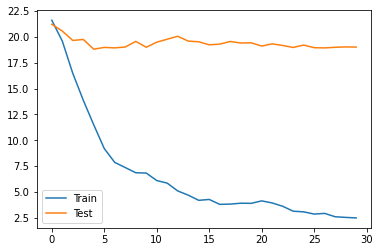

In [16]:
plt.plot(model_his.history['mae'], label='Train')
plt.plot(model_his.history['val_mae'],label='Test')
plt.legend()
plt.show()

### 4e. Save the model

In [ ]:
model.save("predict_model")

### 4f. predict the location with the model and save the result

In [ ]:
test_y = []
test_x = []
for img in test_df['id']:
    img = img + filetype
    target_image = image.load_img(test_path+img, target_size=(490,680))
    target_image = image.img_to_array(target_image)
    target_image = preprocess_input(target_image)
    target_image = np.expand_dims(target_image, axis=0)
    features = fea_model.predict(target_image)
    prediction = model.predict(features)
    x = prediction[0][0]
    y = prediction[0][1]
    test_x.append(x)
    test_y.append(y)

In [15]:
test_df['x'] = test_x
test_df['y'] = test_y
test_df.to_csv('deep_learning_prediction_v4.csv', index=False, header=True)